In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [4]:
lr = pd.read_csv("lr_results.csv")
rf = pd.read_csv("rf_results.csv")
xgb = pd.read_csv("xgb_results.csv")

print(lr.head())
print(rf.head())
print(xgb.head())

print(lr.shape)
print(rf.shape)
print(xgb.shape)

   drift   raw_acc   sig_acc   iso_acc  raw_conf  sig_conf  iso_conf  \
0    0.0  0.975808  0.999052  0.999386  0.946687  0.999151  0.999194   
1    0.2  0.961641  0.999052  0.999333  0.936695  0.999128  0.999058   
2    0.5  0.883484  0.999122  0.999368  0.919390  0.999009  0.997728   
3    1.0  0.759366  0.999140  0.998806  0.929867  0.998305  0.986430   

    raw_ent   sig_ent   iso_ent model  
0  0.155847  0.005721  0.003526    LR  
1  0.170174  0.005865  0.004291    LR  
2  0.192487  0.006614  0.009990    LR  
3  0.164378  0.010150  0.039404    LR  
   drift   raw_acc   sig_acc   iso_acc  raw_conf  sig_conf  iso_conf  \
0    0.0  0.999491  0.999508  0.999491  0.999401  0.999477  0.999355   
1    0.2  0.999421  0.999403  0.999403  0.999071  0.999453  0.999186   
2    0.5  0.999350  0.999368  0.999350  0.998303  0.999430  0.998724   
3    1.0  0.999122  0.999175  0.999140  0.995440  0.999365  0.996752   

    raw_ent   sig_ent   iso_ent  
0  0.002279  0.004112  0.003197  
1  0.00392

In [7]:
lr["model"] = "LR"
rf["model"] = "RF"
xgb["model"] = "XGB"

final = pd.concat([lr, rf, xgb], ignore_index=True)
final = final.sort_values(["model","drift"])
final.reset_index(drop=True, inplace=True)

final.head(12)


,drift,raw_acc,sig_acc,iso_acc,raw_conf,sig_conf,iso_conf,raw_ent,sig_ent,iso_ent,model
0,0.0,0.975808,0.999052,0.999386,0.946687,0.999151,0.999194,0.155847,0.005721,0.003526,LR
1,0.2,0.961641,0.999052,0.999333,0.936695,0.999128,0.999058,0.170174,0.005865,0.004291,LR
2,0.5,0.883484,0.999122,0.999368,0.919390,0.999009,0.997728,0.192487,0.006614,0.009990,LR
3,1.0,0.759366,0.999140,0.998806,0.929867,0.998305,0.986430,0.164378,0.010150,0.039404,LR
4,0.0,0.999491,0.999508,0.999491,0.999401,0.999477,0.999355,0.002279,0.004112,0.003197,RF
5,0.2,0.999421,0.999403,0.999403,0.999071,0.999453,0.999186,0.003925,0.004178,0.004088,RF
6,0.5,0.999350,0.999368,0.999350,0.998303,0.999430,0.998724,0.008087,0.004258,0.006525,RF
7,1.0,0.999122,0.999175,0.999140,0.995440,0.999365,0.996752,0.023106,0.004538,0.017075,RF
8,0.0,0.999579,0.999579,0.999561,0.999884,0.999483,0.999493,0.000486,0.003851,0.003075,XGB
9,0.2,0.999491,0.999544,0.999491,0.999832,0.999486,0.999382,0.000638,0.003880,0.003545,XGB


In [8]:
final.to_csv("final_results.csv", index=False)
print("Saved final_results.csv")


Saved final_results.csv


In [23]:
weight_sets = [
    (0.33, 0.33, 0.33),
    (0.2, 0.4, 0.4),
    (0.1, 0.45, 0.45),
    (0.4, 0.3, 0.3),
    (0.25, 0.25, 0.5)
]


In [24]:
def weighted_reliability(df, w):
    base = df[df["drift"] == df["drift"].min()]
    last = df[df["drift"] == df["drift"].max()]

    da = abs(last["raw_acc"].values[0] - base["raw_acc"].values[0])
    dc = abs(last["raw_conf"].values[0] - base["raw_conf"].values[0])
    de = abs(last["raw_ent"].values[0] - base["raw_ent"].values[0])

    return round(w[0]*da + w[1]*dc + w[2]*de, 5)


In [25]:
ranking_results = []

for w in weight_sets:
    row = {"Weights": w}
    for model in final["model"].unique():
        df_m = final[final["model"] == model].sort_values("drift")
        row[model] = weighted_reliability(df_m, w)
    ranking_results.append(row)

rank_df = pd.DataFrame(ranking_results)
rank_df


,Weights,LR,RF,XGB
0,"(0.33, 0.33, 0.33)",0.07979,0.00830,0.00070
1,"(0.2, 0.4, 0.4)",0.05343,0.00999,0.00075
2,"(0.1, 0.45, 0.45)",0.03305,0.01119,0.00078
3,"(0.4, 0.3, 0.3)",0.09418,0.00758,0.00069
4,"(0.25, 0.25, 0.5)",0.06258,0.01150,0.00085


In [26]:
rank_only = rank_df.copy()

for i in range(len(rank_only)):
    scores = rank_only.loc[i, final["model"].unique()]
    rank_only.loc[i, final["model"].unique()] = scores.rank(ascending=False)

rank_only


,Weights,LR,RF,XGB
0,"(0.33, 0.33, 0.33)",1.0,2.0,3.0
1,"(0.2, 0.4, 0.4)",1.0,2.0,3.0
2,"(0.1, 0.45, 0.45)",1.0,2.0,3.0
3,"(0.4, 0.3, 0.3)",1.0,2.0,3.0
4,"(0.25, 0.25, 0.5)",1.0,2.0,3.0


In [19]:
def reliability_score(df):
    base = df[df["drift"] == df["drift"].min()]
    last = df[df["drift"] == df["drift"].max()]

    dc = abs(last["raw_conf"].values[0] - base["raw_conf"].values[0])
    de = abs(last["raw_ent"].values[0] - base["raw_ent"].values[0])
    da = abs(last["raw_acc"].values[0] - base["raw_acc"].values[0])

    score = (dc + de + da) / 3
    return round(score, 4)


In [22]:
scores = []

for model in final["model"].unique():
    df_model = final[final["model"] == model].sort_values("drift")
    score = reliability_score(df_model)
    scores.append([model, score])

scores_df = pd.DataFrame(scores, columns=["Model", "Reliability_Score"])
scores_df

scores_df["Rank"] = scores_df["Reliability_Score"].rank(ascending=False)
scores_df.sort_values("Rank")


,Model,Reliability_Score,Rank
0,LR,0.0806,1.0
1,RF,0.0084,2.0
2,XGB,0.0007,3.0


In [ ]:
lr_d = pd.read_csv("../results/lr_drift_types.csv")
rf_d = pd.read_csv("../results/rf_drift_types.csv")
xgb_d = pd.read_csv("../results/xgb_drift_types.csv")

drift_types_final = pd.concat([lr_d, rf_d, xgb_d], ignore_index=True)
drift_final = drift_types_final.copy()

drift_types_final.to_csv("drift_types_final.csv", index=False)

drift_types_final.head()


,drift_type,drift,raw_acc,raw_conf,raw_ent,model
0,noise,0.0,0.975808,0.946687,0.155847,Logistic Regression
1,noise,0.2,0.962256,0.937333,0.169475,Logistic Regression
2,noise,0.5,0.883010,0.919425,0.192380,Logistic Regression
3,noise,1.0,0.757136,0.928785,0.165507,Logistic Regression
4,scale,0.0,0.975808,0.946687,0.155847,Logistic Regression


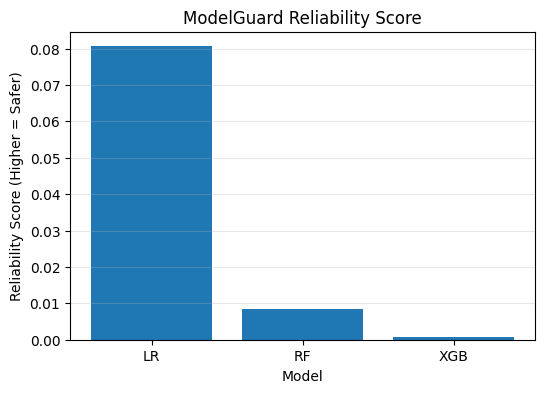

In [21]:
plt.figure(figsize=(6,4))
plt.bar(scores_df["Model"], scores_df["Reliability_Score"])
plt.title("ModelGuard Reliability Score")
plt.ylabel("Reliability Score (Higher = Safer)")
plt.xlabel("Model")
plt.grid(axis="y", alpha=0.3)
plt.show()


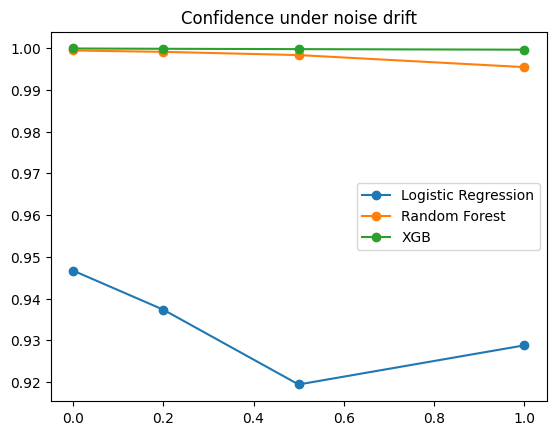

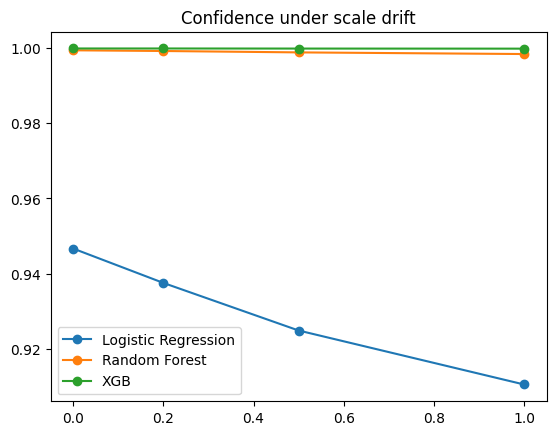

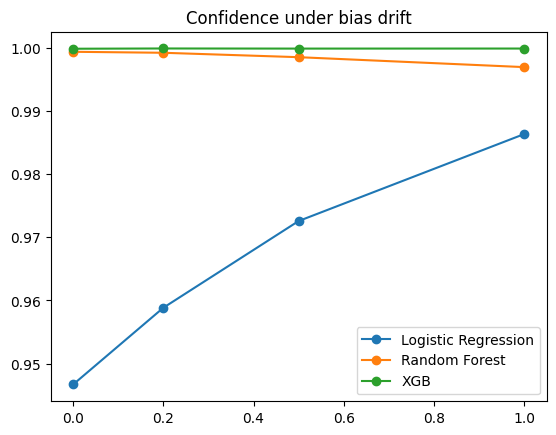

In [31]:
for dtype in drift_final["drift_type"].unique():
    df_t = drift_final[drift_final["drift_type"]==dtype]
    plt.figure()
    for m in df_t["model"].unique():
        d = df_t[df_t["model"]==m]
        plt.plot(d["drift"], d["raw_conf"], marker="o", label=m)
    plt.title(f"Confidence under {dtype} drift")
    plt.legend()
    plt.show()
